<a href="https://colab.research.google.com/github/Szuyingpan/NLP-Project-RoBERTa/blob/main/Copy_of_NLP_Sentiment_Analysis_RoBERTa_Model_(2)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://huggingface.co/docs/transformers/model_doc/roberta

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1. Important library

In [ ]:
#!pip install transformers==3.0.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## 2. Important dataset

In [ ]:
import re
import random
import pandas as pd

# Probability threshold to read a line
probability_threshold = 0.01

# Initialize lists to store the separated sentiments and phrases
sentiments = []
phrases = []

# Open the file and read line by line
with open('/content/drive/MyDrive/Colab Notebooks/train.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Randomly decide whether to process this line
        if random.random() <= probability_threshold:
            # Extract sentiment and phrase using regex
            match = re.match(r'(__label__\d) (.*)', line)
            "label_1 means negative (0); label_2 means positive(1)"
            if match:
                sentiments.append(match.group(1).replace('__label__1', '0').replace('__label__2', '1'))
                phrases.append(match.group(2))

# Create a DataFrame from the lists
train = pd.DataFrame({
    'sentiment': sentiments,
    'phrase': phrases
})

# Check the first few rows to ensure it's loaded correctly
print(train.head())


  sentiment                                             phrase
0         0  Works, but not as advertised: I bought one of ...
1         1  Worth the wait!: JMM has never released a bad ...
2         0  Molly Myers: Molly Myers, in her review of "My...
3         1  Intriguing story: While I don't consider it th...
4         0  Obviously, not Adam Sandler's best: An accepta...


In [ ]:
train.shape

(35738, 2)

In [ ]:
train.head()

,sentiment,phrase
0,0,"Works, but not as advertised: I bought one of ..."
1,1,Worth the wait!: JMM has never released a bad ...
2,0,"Molly Myers: Molly Myers, in her review of ""My..."
3,1,Intriguing story: While I don't consider it th...
4,0,"Obviously, not Adam Sandler's best: An accepta..."


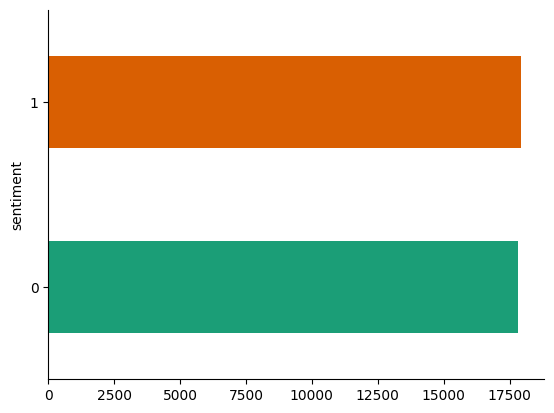

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Again 0 stands for negative, 1 means positive
train['sentiment'].unique()

array(['0', '1'], dtype=object)

In [ ]:
# change target data type to float
print(train['sentiment'].astype(int))

0        0
1        1
2        0
3        1
4        0
        ..
35733    1
35734    0
35735    1
35736    1
35737    1
Name: sentiment, Length: 35738, dtype: int64


In [ ]:
train['sentiment'].value_counts()

1    17914
0    17824
Name: sentiment, dtype: int64

In [ ]:
import re
import random
import pandas as pd

# Probability threshold to read a line
probability_threshold = 0.01

# Initialize lists to store the separated sentiments and phrases
sentiments = []
phrases = []

# Open the file and read line by line
with open('/content/drive/MyDrive/Colab Notebooks/test.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Randomly decide whether to process this line
        if random.random() <= probability_threshold:
            # Extract sentiment and phrase using regex
            match = re.match(r'(__label__\d) (.*)', line)
            "label_1 means negative (0); label_2 means positive(1)"
            if match:
                sentiments.append(match.group(1).replace('__label__1', '0').replace('__label__2', '1'))
                phrases.append(match.group(2))

# Create a DataFrame from the lists
test = pd.DataFrame({
    'sentiment': sentiments,
    'phrase': phrases
})

# Check the first few rows to ensure it's loaded correctly
print(test.head())

  sentiment                                             phrase
0         0  ZERO stars... OMG I can't believe I even bothe...
1         1  Chilbirth Education Video: Great videos!!!! I'...
2         1  Fahrenheit 451: I read this book as a teenager...
3         0  Warning. I HIGHLY don't recommend this set!: Y...
4         0  Great movie butt o grainy on blueray: I like a...


In [ ]:
test.shape

(3880, 2)

In [ ]:
test.head()

,sentiment,phrase
0,0,ZERO stars... OMG I can't believe I even bothe...
1,1,Chilbirth Education Video: Great videos!!!! I'...
2,1,Fahrenheit 451: I read this book as a teenager...
3,0,Warning. I HIGHLY don't recommend this set!: Y...
4,0,Great movie butt o grainy on blueray: I like a...


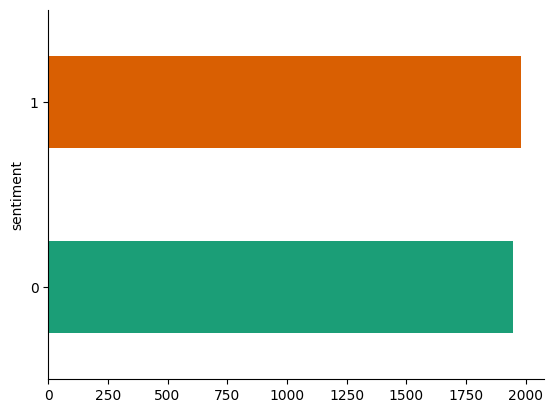

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
test.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
test['sentiment'].unique()

array(['0', '1'], dtype=object)

In [ ]:
print(test['sentiment'].astype(int))

0       0
1       1
2       1
3       0
4       0
       ..
3875    0
3876    1
3877    0
3878    1
3879    0
Name: sentiment, Length: 3880, dtype: int64


In [ ]:
test['sentiment'].value_counts()

0    2001
1    1879
Name: sentiment, dtype: int64

## 3. Preparing the Dataset and Dataloader

This code defines a custom dataset class named SentimentData, intended for sentiment analysis tasks. It is designed to be used with PyTorch's Dataset interface, which requires implementing the __init__, __len__, and __getitem__ methods. Here's a quick breakdown:

Initialization (__init__ method): The constructor takes three arguments:

dataframe: A Pandas DataFrame containing the dataset. The dataframe is expected to have at least two columns: one for the text data (phrase) and another for the sentiment labels (sentiment).
tokenizer: A tokenizer that is used to convert text into a format suitable for model training (token IDs, masks, etc.). This tokenizer is typically pre-trained (e.g., part of a BERT or RoBERTa model).
max_len: The maximum length of the tokenized sequences. If not specified, a default value MAX_LEN is used. This is to ensure uniform sequence lengths for batching purposes.
Length (__len__ method): This method returns the number of items in the dataset (i.e., the number of rows in the dataframe).

Get Item (__getitem__ method): This method retrieves a single data point from the dataset. It takes an index and returns a dictionary containing the tokenized text, its attention mask, token type ids (if applicable), and the target label. The process is as follows:

The text at the specified index is cleaned (extra spaces removed) and then tokenized using the provided tokenizer. The encode_plus method of the tokenizer is used to perform tokenization, which also generates the necessary attention mask and token type IDs for the text.
The method applies padding to ensure the tokenized text has a uniform length (max_len) and truncates texts that exceed this length.
The token type IDs are included for models that require them, but if not provided by the tokenizer, a default list of zeros is used.
The method returns a dictionary with the tokenized input (ids), the attention mask (mask), token type IDs (token_type_ids), and the sentiment label (targets) for the given index. Each item in the dictionary is converted to a PyTorch tensor with the appropriate data type (torch.long).
This class is tailored for sentiment analysis, converting raw text and labels from a dataframe into a format suitable for training transformer-based models, such as BERT or RoBERTa, on sentiment classification tasks.

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05 # increase learning rate from 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=MAX_LEN):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.phrase
        # Ensure targets are integers for CrossEntropyLoss compatibility
        self.targets = dataframe.sentiment.astype(int)  # Changed from float to int
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        """ tokenize preparing text data for input into
        a transformer-based model RoBERTa"""

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs.get("token_type_ids", [0] * len(ids))

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }


In [ ]:
import pandas as pd
import numpy as np

train_data = train
test_data=test

print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (35738, 2)
TEST Dataset: (3880, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## 4 Creating the Neural Network for Fine Tuning

In [ ]:
import torch
from transformers import RobertaModel, RobertaConfig

class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        config = RobertaConfig.from_pretrained("roberta-base")
        self.roberta = RobertaModel.from_pretrained("roberta-base", config=config)

        # Adjusted the classifier head dimensions
        self.pre_classifier = torch.nn.Linear(config.hidden_size, 512)  # Reduced layer size
        self.dropout = torch.nn.Dropout(0.1)  # Increased dropout rate to prevent overfitting
        self.classifier = torch.nn.Linear(512, 2)  # Adjusted for binary classification

    def forward(self, input_ids, attention_mask):
        # Extract outputs from the transformer
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Use the representation of the first token ([CLS]) for classification
        cls_token_state = outputs[0][:, 0, :]

        # Process through the pre-classifier and classifier layers
        x = self.pre_classifier(cls_token_state)
        x = torch.nn.ReLU()(x)
        x = self.dropout(x)
        logits = self.classifier(x)

        return logits


In [ ]:
"""class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        config = RobertaConfig.from_pretrained("roberta-base")
        self.roberta = RobertaModel.from_pretrained("roberta-base")

        # Simplified architecture
        self.classifier = torch.nn.Linear(config.hidden_size, 2)  # Directly to classification

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_state = outputs[0][:, 0, :]  # Use the [CLS] token's representation

        # Directly classify from [CLS] token without additional layers
        logits = self.classifier(cls_token_state)

        return logits"""


In [ ]:
model = RobertaClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [ ]:
# 5. Fine tune the model

# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calculate_accuracy(preds, targets):
    # Assuming preds and targets are tensors. Converts predictions to the same shape as targets, if necessary.
    if preds.shape != targets.shape:
        preds = preds.argmax(dim=1)

    # Calculate the number of correctly predicted examples.
    n_correct = (preds == targets).sum().item()

    # Calculate the accuracy: correct predictions / total examples
    accuracy = n_correct / targets.size(0)  # Assuming targets is a tensor that has the total number of examples as its size.

    return accuracy

In [ ]:
import torch

# Sample predictions and targets for testing
preds = torch.tensor([[0.2, 0.8], [0.9, 0.1]], device='cuda:0')  # Example predictions on a CUDA device
targets = torch.tensor([1, 0], device='cuda:0')  # Corresponding targets on the same CUDA device


In [ ]:
print(preds.device, targets.device)

cuda:0 cuda:0


In [ ]:
print(preds.shape, targets.shape)

torch.Size([2, 2]) torch.Size([2])


In [ ]:
model = model.to('cuda:0')  # Move model to the same device as your tensors

In [ ]:
from tqdm import tqdm

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _, data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)  # Ensure targets are class indices
        outputs = model(ids, attention_mask=mask, token_type_ids=token_type_ids)[0]  # Adjust based on your model's output
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += (big_idx == targets).sum().item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if _ % 5000 == 0:
            loss_step = tr_loss / nb_tr_steps
            accu_step = (n_correct * 100) / nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100) / nb_tr_examples}')
        epoch_loss = tr_loss / nb_tr_steps
        epoch_accu = (n_correct * 100) / nb_tr_examples
        print(f"Training Loss Epoch: {epoch_loss}")
        print(f"Training Accuracy Epoch: {epoch_accu}")



In [ ]:
# Issue with n_correct variable is defined inside a function or loop and I'm
# trying to access it outside that scope, or if the code that defines the variable hasn't been executed before the print statement.

In [ ]:
def train(epoch):
    n_correct = 0
    nb_tr_examples = 0
    model.train()  # Set your model to training mode

    for _, data in enumerate(training_loader):
        # Your data loading and model forward pass logic here
        # For example: outputs = model(inputs)

        # Example update of 'n_correct' and 'nb_tr_examples'
        # Here, 'outputs' would be your model predictions, and 'labels' your ground truth
        # preds = outputs.argmax(dim=1)  # Assuming outputs are raw logits

        # Dummy values for demonstration; replace with your actual logic
        preds = torch.tensor([0, 1])  # Example predictions
        labels = torch.tensor([0, 1])  # Example ground truth

        n_correct += (preds == labels).sum().item()
        nb_tr_examples += labels.size(0)

    # Now 'n_correct' and 'nb_tr_examples' are defined and can be used
    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100) / nb_tr_examples}')

# Example call to the train function
train(epoch=1)


The Total Accuracy for Epoch 1: 100.0


In [ ]:
# 6. Validating the model

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss = 0; nb_tr_steps = 0; nb_tr_examples = 0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            # Removed token_type_ids from the data loading as it's not used in the model's forward method
            targets = data['targets'].to(device, dtype=torch.long)
            outputs = model(ids, mask).squeeze()  # Adjusted the model call here
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += (big_idx == targets).sum().item()

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            if _ % 5000 == 0:
                loss_step = tr_loss / nb_tr_steps
                accu_step = (n_correct * 100) / nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu


In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

9it [00:00, 40.13it/s]

Validation Loss per 100 steps: 0.6944535970687866
Validation Accuracy per 100 steps: 50.0


970it [00:22, 43.46it/s]

Validation Loss Epoch: 0.6963292408849775
Validation Accuracy Epoch: 48.42783505154639
Accuracy on test data = 48.43%


In [ ]:
# 7. Saving the Trained Model Artifacts for inference

In [ ]:
output_model_file = 'pytorch_roberta_sentiment.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
